Adapted from:
<a href="https://colab.research.google.com/github/flatplanet/Pytorch-Tutorial-Youtube/blob/main/simple_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import project_functions as pf
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import csv
import plotly
#import plotly.graph_obcalled_listects as go
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import unittest
import os
from sklearn.model_selection import train_test_split



## To train the second neural net...
1. Reconcile the different dates.
2. Choosing a reasonable range of dates for the inputs. We will start from 2019 because that is when copper data becomes actually available. 
3. Making summary statistics for the months worth of daily data (5 and 15 DMA can be reasonable here). This is not available for copper as unforutnately, the data is monthly since 2019. So we will just paste the associated copper closing price
4. We will run through all the 5 and 15 dmas for the rest of the data. THEN, we will selectively extract the ones that most "line up" with our time.
5. Apparently, oil, gold, and silver are not  daily data but monthly. It is s till good to use the trailing values, but in thise case, as we are conforming the latest date to end on January 2016 for all data sets, we can use the helpful subset index. We will not have daily move averages, but rather it will be the moving average of months. In this case, it actually makes sense to change our values to 6 and 12 to represent half a year and a year

In [40]:
#The Second Model is based on price data of different metals as well as oil, a commodity

#All dataframes are on the candle distribution unless otherwise stated. 
cu_df = pd.read_csv("Relevant Data/copper.csv")
#copper
au_df = pd.read_csv("Relevant Data/gold.csv")
#gold
ag_df = pd.read_csv("Relevant Data/silver.csv")
#silver
oil_df = pd.read_csv("Relevant Data/oil.csv")
#Extract the part of titanium ppi we actually need to use
ti_ppi_df = pd.read_csv("Relevant Data/ti_ppi_df.csv")
m_2_input_df = ti_ppi_df.iloc[:, [0, 1, 2, 8]]
m_2_input_df.columns = ["the_index", "date", "ti_ppi", "ti_ppi_pc"]
m_2_input_df = m_2_input_df[-85:]

#cut the dataframe down to the start of 2019. 
#add copper price
m_2_input_df["cu_p"] = list(cu_df["close"][-85:])

#It is now mma because its monthly moving average
au_df["mma_6"] = pf.calc_mean_from_index(au_df, 6)
au_df["mma_12"] = pf.calc_mean_from_index(au_df, 12)

oil_df["mma_6"] = pf.calc_mean_from_index(oil_df, 6)
oil_df["mma_12"] = pf.calc_mean_from_index(oil_df, 12)

ag_df["mma_6"] = pf.calc_mean_from_index(ag_df, 6)
ag_df["mma_12"] = pf.calc_mean_from_index(ag_df, 12)

#Now to complete the input data set (before we scale the inputs between 0 and 1) 



In [41]:
m_2_input_df["au_c"] = list(au_df["close"][-85:])
m_2_input_df["au_mma6"] = list(au_df["mma_6"][-85:])
m_2_input_df["au_mma12"] = list(au_df["mma_12"][-85:])

m_2_input_df["ag_c"] = list(ag_df["close"][-85:])
m_2_input_df["ag_mma6"] = list(ag_df["mma_6"][-85:])
m_2_input_df["ag_mma12"] = list(ag_df["mma_12"][-85:])

m_2_input_df["oil_c"] = list(ag_df["close"][-85:])
m_2_input_df["oil_mma6"] = list(ag_df["mma_6"][-85:])
m_2_input_df["oil_mma12"] = list(ag_df["mma_12"][-85:])
#m_2_input_df.to_csv('Relevant Data/m_2_input_df.csv', index=False)



In [42]:
# Model_2 is based on the price of other metals also on a monthly basis as well as rolling monthly averages
class Model_2(nn.Module):
  # Input layer (Now we have 12 inputs) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (I want one numeric prediction)
  def __init__(self, in_features=12, h1=12, h2=10, out_features=1):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x


In [43]:
# Pick a manual seed for randomization
torch.manual_seed(37)
# Create an instance of model
model = Model_2()
my_df = pd.read_csv("Relevant Data/m_2_input_df.csv")
# Remove the last row as it doesn't have the associated prediction. 
my_df = my_df.iloc[:-1]


#transform my_df into a [0, 1] scaled matrix. Let's drop the date as we dont' need it for reference anymore
my_df = my_df.drop('date', axis=1)


t_back_min, t_back_max = min(my_df['ti_ppi_pc']), max(my_df['ti_ppi_pc'])
#Transform back minimun and maximun



my_df_scaled = my_df
my_df_scaled['the_index'] = pf.scale01(my_df_scaled['the_index'])
my_df_scaled['ti_ppi'] = pf.scale01(my_df_scaled['ti_ppi'])
my_df_scaled['ti_ppi_pc'] = pf.scale01(my_df_scaled['ti_ppi_pc'])
my_df_scaled['cu_p'] = pf.scale01(my_df_scaled['cu_p'])
my_df_scaled['au_c'] = pf.scale01(my_df_scaled['au_c'])
my_df_scaled['au_mma6'] = pf.scale01(my_df_scaled['au_mma6'])
my_df_scaled['au_mma12'] = pf.scale01(my_df_scaled['au_mma12'])
my_df_scaled['ag_c'] = pf.scale01(my_df_scaled['ag_c'])
my_df_scaled['ag_mma6'] = pf.scale01(my_df_scaled['ag_mma6'])
my_df_scaled['ag_mma12'] = pf.scale01(my_df_scaled['ag_mma12'])
my_df_scaled['oil_c'] = pf.scale01(my_df_scaled['oil_c'])
my_df_scaled['oil_mma6'] = pf.scale01(my_df_scaled['oil_mma6'])
my_df_scaled['oil_mma12'] = pf.scale01(my_df_scaled['oil_mma12'])





In [45]:
# Train Test Split!  Set X, y
X = my_df_scaled
X = X.drop('ti_ppi_pc', axis=1)
y = my_df_scaled['ti_ppi_pc']
# Convert these to numpy arrays
X = X.values
y = y.values
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to float tensors
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Set the criterion of model to measure the error, how far off the predictions are from the data - PyTorch Forum suggest MSELoss
criterion = nn.MSELoss()
# Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 200
losses = []
#set this parameter to try to resolve error

for i in range(epochs):
  # Go forward and get a prediction
    y_pred = model.forward(X_train) # Get predicted results
    y_pred = y_pred[:,0]

  # Measure the loss/error, gonna be high at first

    loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses
    losses.append(loss.detach().numpy())

  # print every 10 epoch
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of forward propagation and feed it back
  # thru the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0 and loss: 0.2497541457414627
Epoch: 10 and loss: 0.045802872627973557
Epoch: 20 and loss: 0.025618037208914757
Epoch: 30 and loss: 0.020866526290774345
Epoch: 40 and loss: 0.02047528326511383
Epoch: 50 and loss: 0.020581068471074104
Epoch: 60 and loss: 0.02050473913550377
Epoch: 70 and loss: 0.020411232486367226
Epoch: 80 and loss: 0.02034084126353264
Epoch: 90 and loss: 0.020279107615351677
Epoch: 100 and loss: 0.02021673694252968
Epoch: 110 and loss: 0.020148450508713722
Epoch: 120 and loss: 0.02007184363901615
Epoch: 130 and loss: 0.01998569257557392
Epoch: 140 and loss: 0.019890177994966507
Epoch: 150 and loss: 0.019786842167377472
Epoch: 160 and loss: 0.019678214564919472
Epoch: 170 and loss: 0.019567666575312614
Epoch: 180 and loss: 0.019458919763565063
Epoch: 190 and loss: 0.0193550493568182


Text(0.5, 0, 'Epoch')

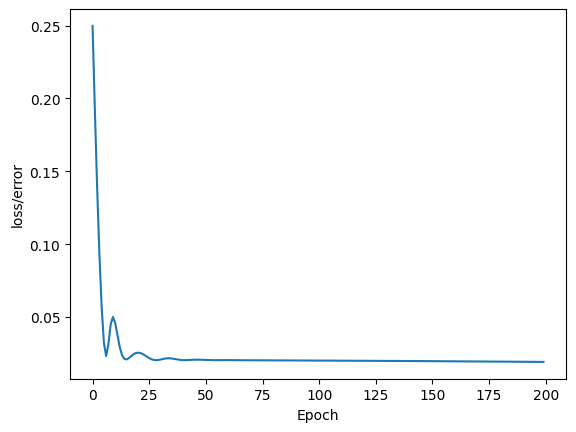

In [46]:
# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

In [47]:
# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    y_eval = y_eval[:,0]
    loss = criterion(y_eval, y_test) # Find the loss or error


Text(0, 0.5, 'Change in Percentage')

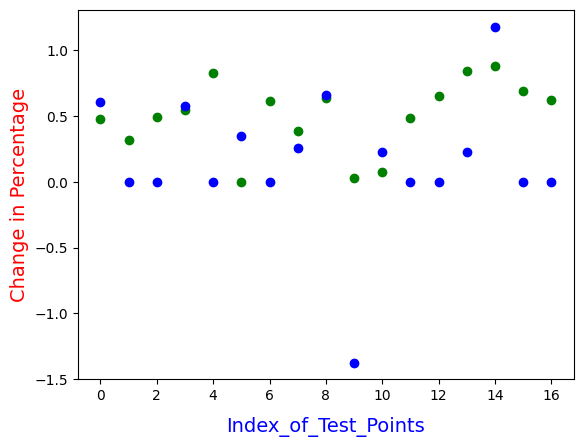

In [55]:

y_eval_t_b = pf.scale01_t_back(y_eval, t_back_min, t_back_max)
y_test_t_b = pf.scale01_t_back(y_test, t_back_min, t_back_max)

plt.scatter(range(len(y_eval_t_b)) , y_eval_t_b, c='green', label='Predicted' ) 
plt.scatter(range(len(y_test_t_b)) , y_test_t_b, c='blue', label='Actual' ) 

plt.xlabel("Index_of_Test_Points", fontsize=14, color='blue', labelpad=10)
plt.ylabel("Change in Percentage", fontsize=14, color='red', rotation=90)


We are 99% confident that our predictions are correct within +/- 176.0137481689453 basis points of the ML model output.


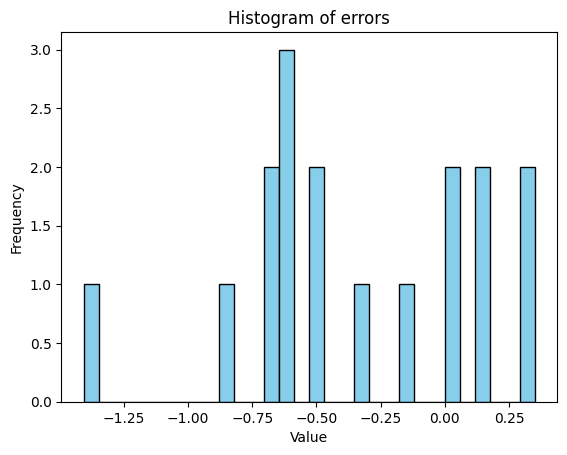

In [49]:
#Calculate uncertainties / error associated with model - Statement of confidence associated with prediction

nn_2_errors = y_test_t_b - y_eval_t_b


std_dev_nn_1 = np.std(nn_2_errors)
safety_factor = 1.5

#k-value for 99% confidence
conf_99 = 2.576

margin_of_error = conf_99 * safety_factor * std_dev_nn_1 * 100
#Multiplying it by 100 because it is originally stated in percent change as we are defining it in basis poitns

print(f"We are 99% confident that our predictions are correct within +/- {margin_of_error} basis points of the ML model output." )

plt.hist(nn_2_errors, bins=30, color='skyblue', edgecolor='black') # `bins` defines the number of intervals

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of errors')

# 4. Display the plot
plt.show()




In [51]:
# Save our NN Model
torch.save(model.state_dict(), 'M2_PPI_reg.pt')
# Load the Saved Model

saved_model = Model_2()
saved_model.load_state_dict(torch.load('M2_PPI_reg.pt', weights_only=False))
#Confirms that our saved model is indeed what we expect
saved_model.eval()


Model_2(
  (fc1): Linear(in_features=12, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [53]:
next_month_Ti_PPI_input = torch.FloatTensor(X[-1])


with torch.no_grad():  # Basically turn off back propogation
    output = saved_model.forward(next_month_Ti_PPI_input) # X_test are features from our test set, y_eval will be predictions

next_month_prediction = pf.scale01_t_back(output, t_back_min, t_back_max)
print(f"We are 99% confident that the price change from {ti_ppi_df["time"][len(ti_ppi_df["time"])-2]} to {ti_ppi_df["time"][len(ti_ppi_df["time"])-1]} is between { round((next_month_prediction[0] * 100  - margin_of_error)[0], 2) } and { round((next_month_prediction[0] * 100 + margin_of_error)[0], 2) } basis points. ")
print(f"This prediction is validated by the most recent basis point change of {ti_ppi_df["percent_change"] [len(ti_ppi_df["percent_change"]) - 2] * 100 }.")


We are 99% confident that the price change from 12/1/2025 to 1/1/2026 is between -186.85000610351562 and 165.17999267578125 basis points. 
This prediction is validated by the most recent basis point change of 29.91452991452942.
